In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from collections import Counter

# --- TensorFlow 2.15.0 AYARLARI ---
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# TF 2.15'te Keras, tensorflow'un alt modülüdür.
# Doğrudan 'import keras' YAPMAYIN, karışıklık çıkabilir.
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, 
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Seed (Tekrarlanabilirlik için)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def load_massive_jsonl(file_path):
    """MASSIVE veri setini yükler"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                item = json.loads(line)
                data.append({
                    'utterance': item['utt'],
                    'intent': item['intent'],
                    'partition': item['partition']
                })
    return pd.DataFrame(data)

# Dosya yolunu kendi yapınıza göre ayarlayın
FILE_PATH = 'tr-TR.jsonl'  # veya '../data/tr-TR.jsonl'

df = load_massive_jsonl(FILE_PATH)

print(f"✓ Veri yüklendi: {len(df)} örnek")
print(f"✓ Intent sınıfı: {df['intent'].nunique()}")
print(f"\nPartition dağılımı:")
print(df['partition'].value_counts())
print(f"\nİlk 5 örnek:")
print(df[['utterance', 'intent']].head())

✓ Veri yüklendi: 16521 örnek
✓ Intent sınıfı: 60

Partition dağılımı:
partition
train    11514
test      2974
dev       2033
Name: count, dtype: int64

İlk 5 örnek:
                              utterance             intent
0     bu hafta beni sabah beşte uyandır          alarm_set
1  beni cuma günü sabah dokuzda uyandır          alarm_set
2          iki saat sonrasına alarm kur          alarm_set
3                                sessiz  audio_volume_mute
4                        olly sessiz ol  audio_volume_mute


✓ Ön işleme tamamlandı
✓ Toplam 60 intent sınıfı


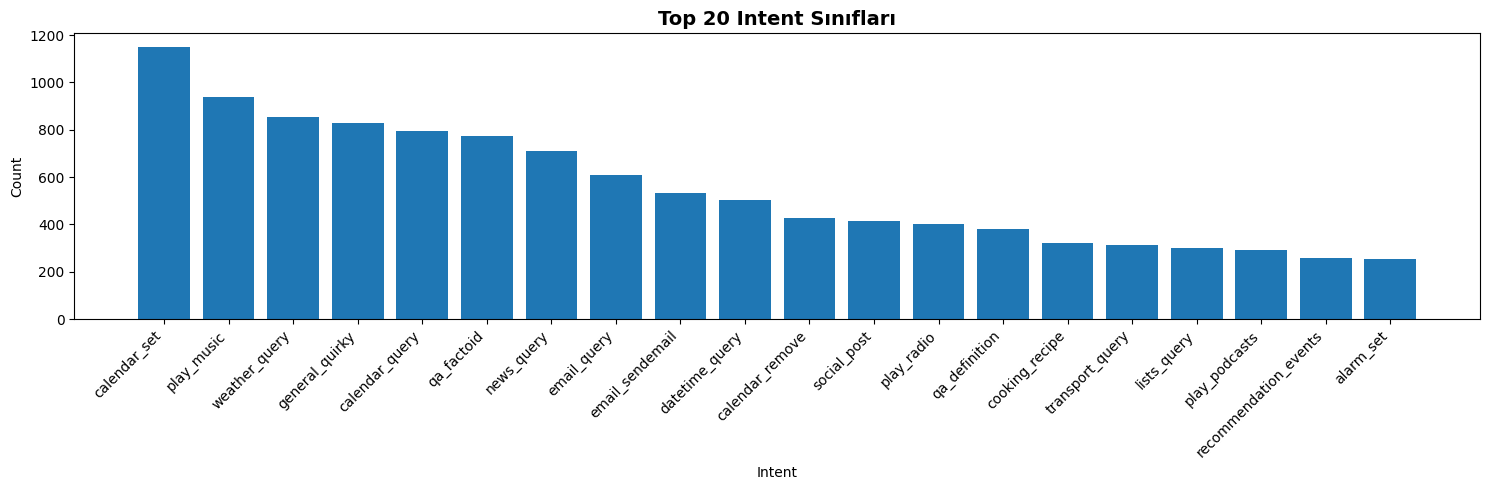

In [3]:
def preprocess_text(text):
    """Türkçe metin temizleme"""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['utterance_clean'] = df['utterance'].apply(preprocess_text)

# Intent encoding
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

print(f"✓ Ön işleme tamamlandı")
print(f"✓ Toplam {len(label_encoder.classes_)} intent sınıfı")

# Intent dağılımını görselleştir
plt.figure(figsize=(15, 5))
top_intents = df['intent'].value_counts().head(20)
plt.bar(range(len(top_intents)), top_intents.values)
plt.xticks(range(len(top_intents)), top_intents.index, rotation=45, ha='right')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.title('Top 20 Intent Sınıfları', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()



✓ Tokenizasyon tamamlandı
✓ Vocabulary size: 12317
✓ X shape: (16521, 25), y shape: (16521,)


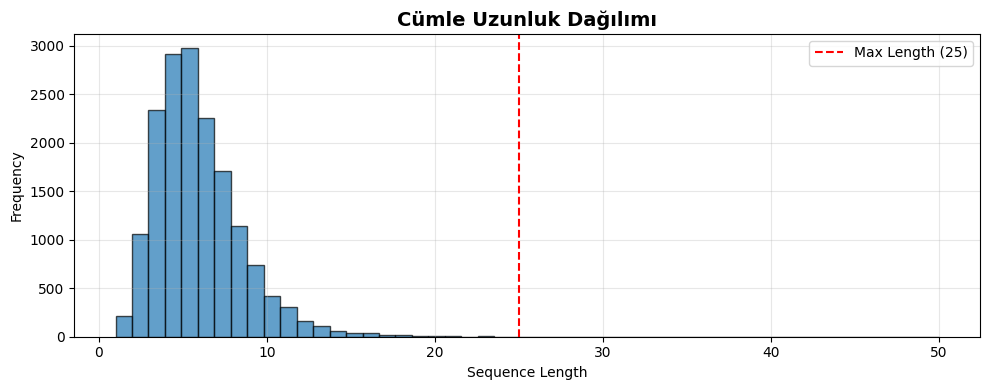

✓ Ortalama uzunluk: 5.51
✓ Max uzunluk: 50


In [5]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 25

# Keras Tokenizer - optimize edilmiş
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>',
    char_level=False
)

tokenizer.fit_on_texts(df['utterance_clean'])
sequences = tokenizer.texts_to_sequences(df['utterance_clean'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y = df['intent_encoded'].values

print(f"✓ Tokenizasyon tamamlandı")
print(f"✓ Vocabulary size: {len(tokenizer.word_index)}")
print(f"✓ X shape: {X.shape}, y shape: {y.shape}")

# Sequence uzunluk dağılımı
seq_lengths = [len(s) for s in sequences]
plt.figure(figsize=(10, 4))
plt.hist(seq_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(MAX_SEQUENCE_LENGTH, color='red', linestyle='--', 
            label=f'Max Length ({MAX_SEQUENCE_LENGTH})')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Cümle Uzunluk Dağılımı', fontsize=14, weight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Ortalama uzunluk: {np.mean(seq_lengths):.2f}")
print(f"✓ Max uzunluk: {max(seq_lengths)}")

In [6]:
train_mask = df['partition'] == 'train'
test_mask = df['partition'] == 'test'
dev_mask = df['partition'] == 'dev'

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Dev varsa kullan, yoksa train'den ayır
if dev_mask.sum() > 0:
    X_val = X[dev_mask]
    y_val = y[dev_mask]
    print("✓ Dev partition kullanıldı")
else:
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
    )
    print("✓ Train'den validation ayrıldı")

NUM_CLASSES = len(label_encoder.classes_)

print(f"\n{'='*50}")
print("VERİ SETİ DAĞILIMI")
print(f"{'='*50}")
print(f"Train:      {len(X_train):>6} örnekler ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val):>6} örnekler ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:       {len(X_test):>6} örnekler ({len(X_test)/len(X)*100:.1f}%)")
print(f"{'='*50}")
print(f"Toplam:     {len(X):>6} örnekler")
print(f"Sınıf sayısı: {NUM_CLASSES}")
print(f"{'='*50}")

✓ Dev partition kullanıldı

VERİ SETİ DAĞILIMI
Train:       11514 örnekler (69.7%)
Validation:   2033 örnekler (12.3%)
Test:         2974 örnekler (18.0%)
Toplam:      16521 örnekler
Sınıf sayısı: 60


In [7]:
def create_optimized_model(vocab_size, embedding_dim, max_length, num_classes):
    """
    Optimize edilmiş 1D-CNN model
    - BatchNormalization eklendi
    - Daha derin mimari
    - Dropout optimize edildi
    """
    model = Sequential([
        # Embedding Layer
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            embeddings_initializer='glorot_uniform',
            name='embedding'
        ),
        
        # First Conv1D Block
        Conv1D(128, 3, activation='relu', padding='same', name='conv1d_1'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Conv1D Block
        Conv1D(128, 3, activation='relu', padding='same', name='conv1d_2'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Global Max Pooling
        GlobalMaxPooling1D(name='global_max_pooling'),
        
        # Dense Layers
        Dense(256, activation='relu', name='dense_1'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', name='dense_2'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output Layer
        Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Model oluştur
EMBEDDING_DIM = 128  # 100'den 128'e artırdık

print("\n" + "="*60)
print("MODEL MİMARİSİ")
print("="*60)

model = create_optimized_model(
    vocab_size=MAX_VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=NUM_CLASSES
)

model.summary()

print(f"\nModel oluşturuldu")
print(f"Toplam parametre: {model.count_params():,}")
print(f"Eğitilebilir parametre: {sum([np.prod(w.shape) for w in model.trainable_weights]):,}")



MODEL MİMARİSİ

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 128)           49280     
                                                                 
 batch_normalization (Batch  (None, 25, 128)           512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 25, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           49280     
                                                                 
 batch_normalization_1 (Bat  (None, 25, 128)           512       
 chNormalization)                      

In [8]:
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model derlendi")
print(f"✓ Optimizer: Adam (lr={initial_learning_rate})")
print(f"✓ Loss: Sparse Categorical Crossentropy")

✓ Model derlendi
✓ Optimizer: Adam (lr=0.001)
✓ Loss: Sparse Categorical Crossentropy


In [9]:
callbacks = [
    # Early Stopping
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Learning Rate Reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Model Checkpoint
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks tanımlandı:")
print("  - EarlyStopping (patience=5)")
print("  - ReduceLROnPlateau (patience=3)")
print("  - ModelCheckpoint")

✓ Callbacks tanımlandı:
  - EarlyStopping (patience=5)
  - ReduceLROnPlateau (patience=3)
  - ModelCheckpoint


In [10]:
print("MODEL EĞİTİMİ BAŞLIYOR")
print("="*60)

BATCH_SIZE = 64
EPOCHS = 20

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("EĞİTİM TAMAMLANDI!")

MODEL EĞİTİMİ BAŞLIYOR
Epoch 1/20


180/180 [==============================] - ETA: 0s - loss: 3.8162 - accuracy: 0.1508
Epoch 1: val_accuracy improved from -inf to 0.05165, saving model to best_model.keras
180/180 [==============================] - 14s 56ms/step - loss: 3.8162 - accuracy: 0.1508 - val_loss: 5.8491 - val_accuracy: 0.0516 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - ETA: 0s - loss: 2.2402 - accuracy: 0.4384
Epoch 2: val_accuracy did not improve from 0.05165
180/180 [==============================] - 8s 42ms/step - loss: 2.2402 - accuracy: 0.4384 - val_loss: 5.3797 - val_accuracy: 0.0516 - lr: 0.0010
Epoch 3/20
179/180 [============================>.] - ETA: 0s - loss: 1.3615 - accuracy: 0.6503
Epoch 3: val_accuracy improved from 0.05165 to 0.23069, saving model to best_model.keras
180/180 [==============================] - 8s 46ms/step - loss: 1.3627 - accuracy: 0.6502 - val_loss: 2.7721 - val_accuracy: 0.2307 - lr: 0.0010
Epoch 4/20
180/180 [=====

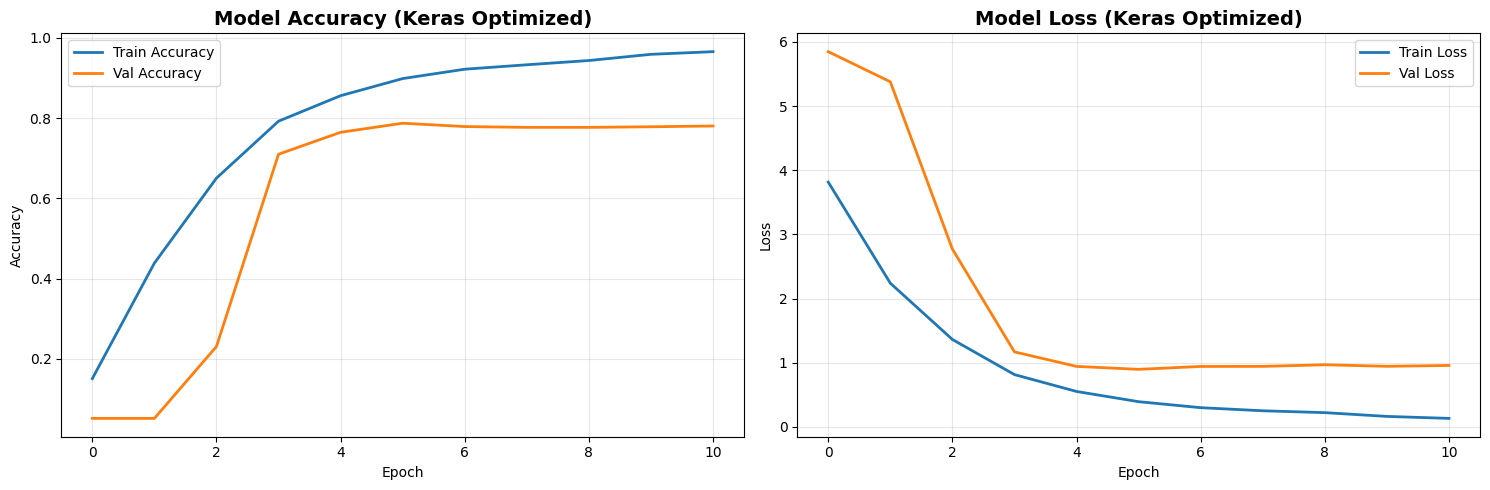


EĞİTİM SONUÇLARI
En iyi epoch: 6
En iyi val accuracy: 0.7870 (78.70%)
Final train accuracy: 0.9653


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy (Keras Optimized)', fontsize=14, weight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss (Keras Optimized)', fontsize=14, weight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# En iyi sonuçları göster
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
print(f"\n{'='*60}")
print("EĞİTİM SONUÇLARI")
print(f"{'='*60}")
print(f"En iyi epoch: {best_epoch + 1}")
print(f"En iyi val accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"{'='*60}")



In [12]:
# =============================================================================
# HÜCRE 11: Test Değerlendirme (KeyError Düzeltilmiş)
# =============================================================================

print("\n" + "="*60)
print("📊 TEST SETİ DEĞERLENDİRMESİ")
print("="*60)

# Test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Predictions
print("Tahminler yapılıyor...")
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Genel metrikler (TÜM test seti için - ÖNCE BU)
print("\n" + "="*60)
print("GENEL METRİKLER (Tüm Test Seti)")
print("="*60)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_classes, average='weighted', zero_division=0
)

print(f"Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)

# Classification Report - Top 20 sınıf için (TAM DÜZELTİLMİŞ)
print("\n" + "="*60)
print("CLASSIFICATION REPORT (Top 20 Sınıf)")
print("="*60)

# Test setinde en sık görülen 20 sınıfı al
test_intent_counts = pd.Series(y_test).value_counts().head(20)
top_classes = test_intent_counts.index.tolist()

# Hem y_test HEM DE y_pred_classes top_classes'te olmalı
mask = np.isin(y_test, top_classes) & np.isin(y_pred_classes, top_classes)
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred_classes[mask]

print(f"Top 20 sınıf için: {mask.sum()} / {len(y_test)} örnek kullanılıyor")

if len(y_test_filtered) > 0:
    # Sadece bu örneklerde görünen sınıflar
    unique_labels = sorted(set(y_test_filtered) | set(y_pred_filtered))
    
    # Label'ları 0'dan başlayacak şekilde map et
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    
    y_test_remapped = np.array([label_mapping[label] for label in y_test_filtered])
    y_pred_remapped = np.array([label_mapping[label] for label in y_pred_filtered])
    
    # Target names
    target_names = [label_encoder.classes_[label] for label in unique_labels]
    
    print(classification_report(
        y_test_remapped,
        y_pred_remapped,
        target_names=target_names,
        digits=4,
        zero_division=0
    ))
else:
    print("⚠️ Top 20 sınıf için yeterli örnek bulunamadı")

# Sınıf başına accuracy (Top 15)
print("\n" + "="*60)
print("SINIF BAŞINA PERFORMANS (Top 15)")
print("="*60)

class_accuracies = []
for intent_idx in test_intent_counts.head(15).index:
    mask = y_test == intent_idx
    if mask.sum() > 0:
        class_acc = (y_pred_classes[mask] == y_test[mask]).mean()
        intent_name = label_encoder.classes_[intent_idx]
        class_accuracies.append({
            'intent': intent_name,
            'accuracy': class_acc,
            'count': mask.sum()
        })

if class_accuracies:
    class_acc_df = pd.DataFrame(class_accuracies)
    class_acc_df = class_acc_df.sort_values('accuracy', ascending=False)
    
    for idx, row in class_acc_df.iterrows():
        print(f"{row['intent']:<35} Acc: {row['accuracy']:.4f} ({int(row['count'])} örnekler)")
else:
    print("Sınıf bilgisi hesaplanamadı")

print("="*60)

# Confusion matrix bilgisi için en çok karıştırılan sınıflar
print("\n" + "="*60)
print("EN ÇOK KARIŞTIRILAN SINIFLAR (Top 10 Hata)")
print("="*60)

# Yanlış tahminler
wrong_mask = y_test != y_pred_classes
wrong_pairs = list(zip(y_test[wrong_mask], y_pred_classes[wrong_mask]))

if wrong_pairs:
    from collections import Counter
    most_common_errors = Counter(wrong_pairs).most_common(10)
    
    for (true_label, pred_label), count in most_common_errors:
        true_intent = label_encoder.classes_[true_label]
        pred_intent = label_encoder.classes_[pred_label]
        print(f"{true_intent:<25} → {pred_intent:<25} ({count} kez)")
else:
    print("Hiç yanlış tahmin yok! (Mükemmel model)")

print("="*60)


📊 TEST SETİ DEĞERLENDİRMESİ

Test Loss: 0.9177
Test Accuracy: 0.7804 (78.04%)
Tahminler yapılıyor...

GENEL METRİKLER (Tüm Test Seti)
Accuracy:  0.7804 (78.04%)
Precision: 0.8065
Recall:    0.7804
F1-Score:  0.7860

CLASSIFICATION REPORT (Top 20 Sınıf)
Top 20 sınıf için: 1932 / 2974 örnek kullanılıyor
                  precision    recall  f1-score   support

  calendar_query     0.6258    0.8083    0.7055       120
 calendar_remove     0.8857    0.9254    0.9051        67
    calendar_set     0.9086    0.8606    0.8840       208
  cooking_recipe     0.9808    0.7391    0.8430        69
  datetime_query     0.9176    0.9176    0.9176        85
     email_query     0.9273    0.8644    0.8947       118
 email_sendemail     0.9608    0.8829    0.9202       111
  general_quirky     0.4571    0.6621    0.5408       145
iot_hue_lightoff     1.0000    0.9474    0.9730        38
     lists_query     0.7593    0.8913    0.8200        46
    lists_remove     0.9318    0.8200    0.8723        50


Confusion Matrix için 10 sınıf seçildi


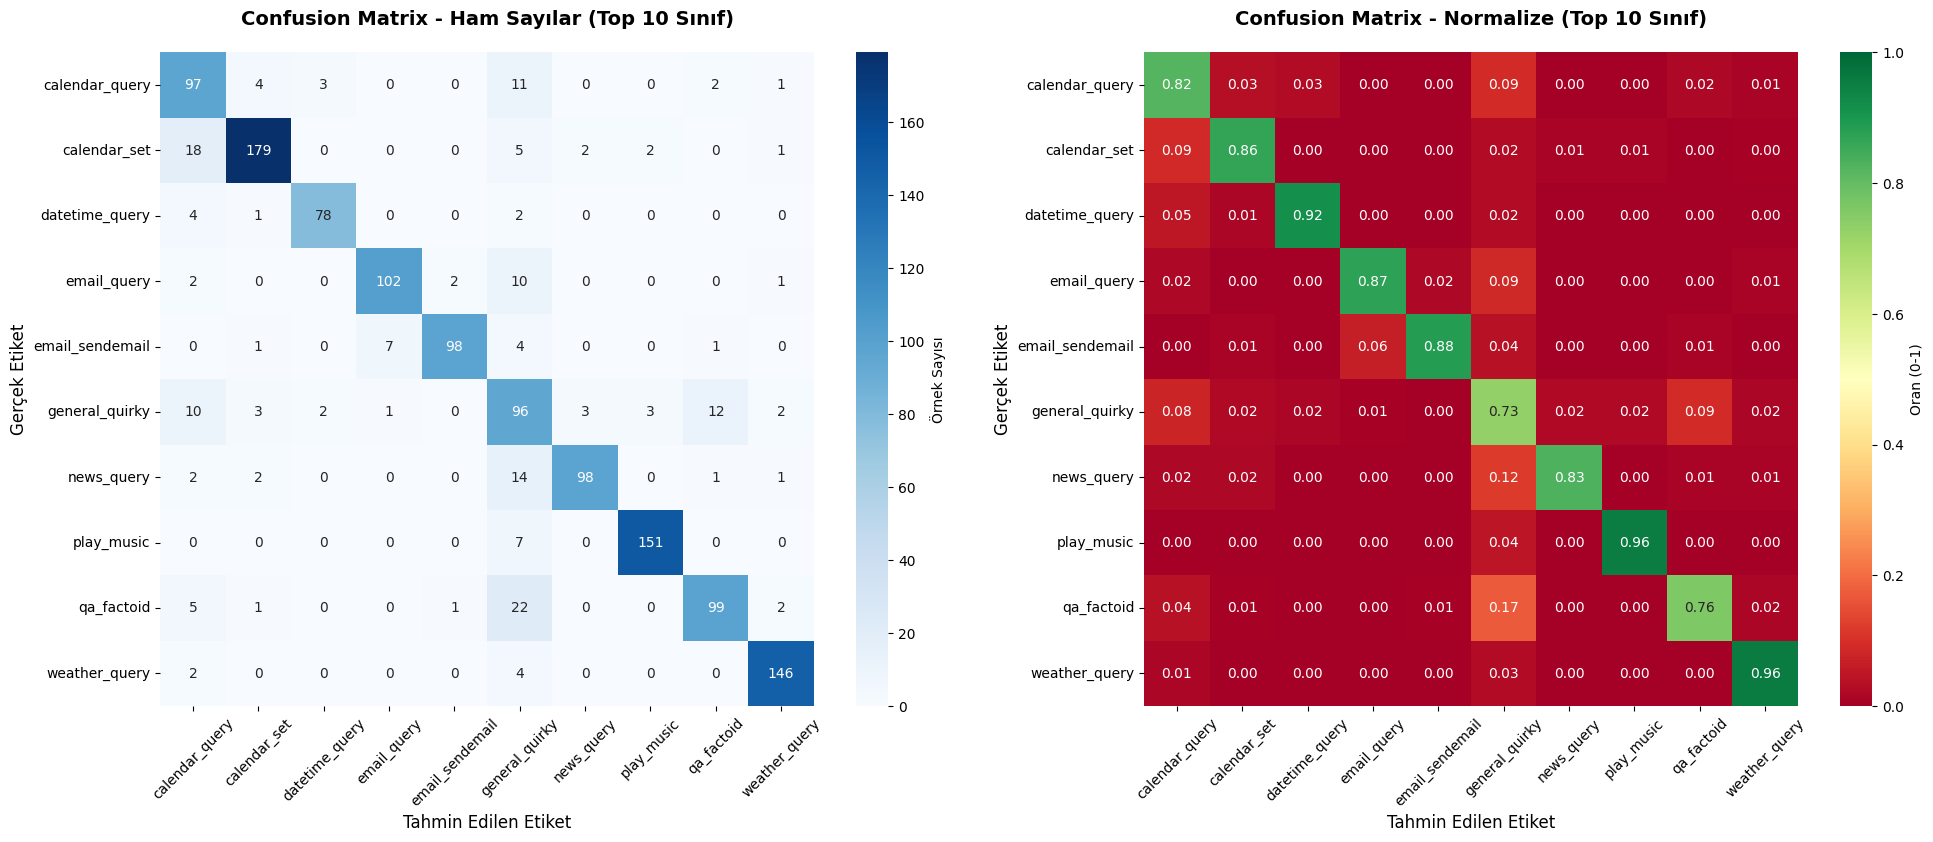


SINIF BAŞINA DOĞRULUK (Confusion Matrix'ten)
calendar_query                       97/118 = 0.822
calendar_set                        179/207 = 0.865
datetime_query                       78/85  = 0.918
email_query                         102/117 = 0.872
email_sendemail                      98/111 = 0.883
general_quirky                       96/132 = 0.727
news_query                           98/118 = 0.831
play_music                          151/158 = 0.956
qa_factoid                           99/130 = 0.762
weather_query                       146/152 = 0.961

EN ÇOK KARIŞTIRILAN ÇIFTLER (Top 10)
qa_factoid                     → general_quirky                 (22 kez)
calendar_set                   → calendar_query                 (18 kez)
news_query                     → general_quirky                 (14 kez)
general_quirky                 → qa_factoid                     (12 kez)
calendar_query                 → general_quirky                 (11 kez)
email_query                    

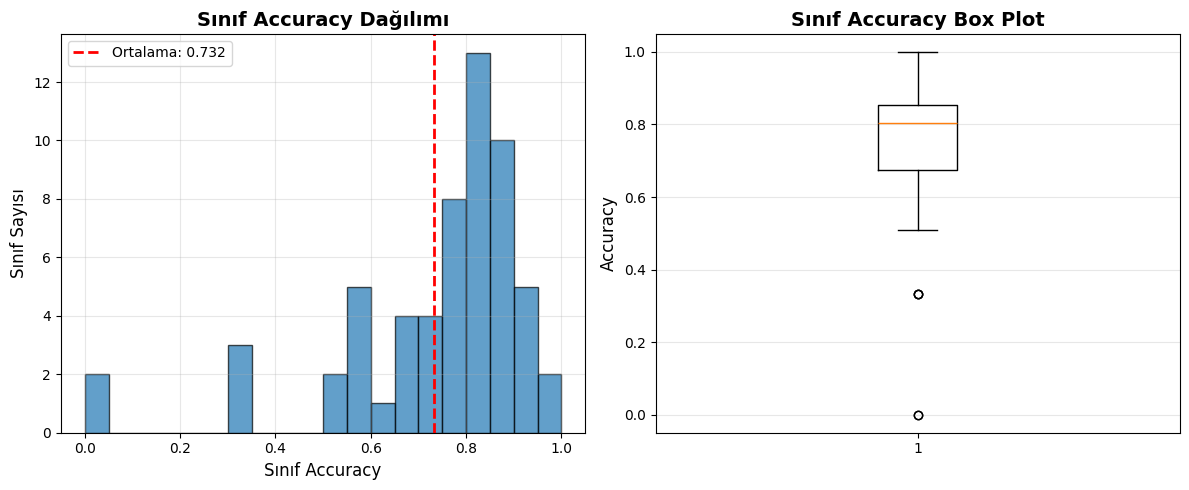

Ortalama sınıf accuracy: 0.7318
Median sınıf accuracy: 0.8039
En düşük accuracy: 0.0000
En yüksek accuracy: 1.0000
Standart sapma: 0.2016


In [13]:
top_n = 10  # 15 yerine 10 (daha okunabilir)

# Test setinde en sık görülen sınıflar
test_counts = pd.Series(y_test).value_counts()
top_true_classes = test_counts.head(top_n).index.tolist()

# Tahminlerde en sık görülen sınıflar
pred_counts = pd.Series(y_pred_classes).value_counts()
top_pred_classes = pred_counts.head(top_n).index.tolist()

# Her iki listede de olan sınıfları al (kesişim)
common_classes = sorted(set(top_true_classes) & set(top_pred_classes))

# Eğer çok az kesişim varsa, union al
if len(common_classes) < 8:
    common_classes = sorted(set(top_true_classes) | set(top_pred_classes))
    common_classes = common_classes[:top_n]  # İlk 10'u al

print(f"\nConfusion Matrix için {len(common_classes)} sınıf seçildi")

# Filtreleme: Sadece seçili sınıflardaki örnekleri al
mask = np.isin(y_test, common_classes) & np.isin(y_pred_classes, common_classes)
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred_classes[mask]

if len(y_test_filtered) > 50:  # En az 50 örnek olmalı
    # Confusion matrix hesapla
    cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=common_classes)
    
    # Intent isimleri
    class_names = [label_encoder.classes_[i] for i in common_classes]
    
    # Kısaltılmış isimler (çok uzunsa)
    class_names_short = []
    for name in class_names:
        if len(name) > 15:
            class_names_short.append(name[:12] + '...')
        else:
            class_names_short.append(name)
    
    # Normalize edilmiş confusion matrix (yüzde olarak)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # NaN'ları 0 yap
    
    # Görselleştirme - 2 ayrı grafik
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. HAM SAYILAR
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names_short,
        yticklabels=class_names_short,
        cbar_kws={'label': 'Örnek Sayısı'},
        ax=axes[0],
        square=True
    )
    axes[0].set_title(f'Confusion Matrix - Ham Sayılar (Top {len(common_classes)} Sınıf)', 
                      fontsize=14, weight='bold', pad=20)
    axes[0].set_ylabel('Gerçek Etiket', fontsize=12)
    axes[0].set_xlabel('Tahmin Edilen Etiket', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # 2. NORMALIZE (Yüzde)
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        xticklabels=class_names_short,
        yticklabels=class_names_short,
        cbar_kws={'label': 'Oran (0-1)'},
        ax=axes[1],
        square=True,
        vmin=0,
        vmax=1
    )
    axes[1].set_title(f'Confusion Matrix - Normalize (Top {len(common_classes)} Sınıf)', 
                      fontsize=14, weight='bold', pad=20)
    axes[1].set_ylabel('Gerçek Etiket', fontsize=12)
    axes[1].set_xlabel('Tahmin Edilen Etiket', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Diagonal (doğru tahminler) analizi
    print("\n" + "="*60)
    print("SINIF BAŞINA DOĞRULUK (Confusion Matrix'ten)")
    print("="*60)
    
    for i, class_idx in enumerate(common_classes):
        total = cm[i].sum()
        correct = cm[i, i]
        accuracy = correct / total if total > 0 else 0
        intent_name = label_encoder.classes_[class_idx]
        print(f"{intent_name:<35} {correct:>3}/{total:<3} = {accuracy:.3f}")
    
    print("="*60)
    
    # En çok karıştırılan çiftler (diagonal dışı)
    print("\n" + "="*60)
    print("EN ÇOK KARIŞTIRILAN ÇIFTLER (Top 10)")
    print("="*60)
    
    confusion_pairs = []
    for i in range(len(common_classes)):
        for j in range(len(common_classes)):
            if i != j and cm[i, j] > 0:  # Diagonal dışı
                confusion_pairs.append({
                    'true': label_encoder.classes_[common_classes[i]],
                    'pred': label_encoder.classes_[common_classes[j]],
                    'count': cm[i, j]
                })
    
    confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)
    
    for pair in confusion_pairs[:10]:
        print(f"{pair['true']:<30} → {pair['pred']:<30} ({pair['count']} kez)")
    
    print("="*60)

else:
    print("⚠️ Yeterli örnek bulunamadı, confusion matrix çizilemiyor")
    print(f"   Filtrelenen örnek sayısı: {len(y_test_filtered)}")

# BONUS: Genel accuracy dağılımı (histogram)
print("\n" + "="*60)
print("SINIF ACCURACY DAĞILIMI")
print("="*60)

# Tüm sınıflar için accuracy hesapla
all_class_accuracies = []
for intent_idx in range(NUM_CLASSES):
    mask = y_test == intent_idx
    if mask.sum() > 0:
        class_acc = (y_pred_classes[mask] == y_test[mask]).mean()
        all_class_accuracies.append(class_acc)

if all_class_accuracies:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(all_class_accuracies, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(all_class_accuracies), color='red', linestyle='--', 
                linewidth=2, label=f'Ortalama: {np.mean(all_class_accuracies):.3f}')
    plt.xlabel('Sınıf Accuracy', fontsize=12)
    plt.ylabel('Sınıf Sayısı', fontsize=12)
    plt.title('Sınıf Accuracy Dağılımı', fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(all_class_accuracies, vert=True)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Sınıf Accuracy Box Plot', fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Ortalama sınıf accuracy: {np.mean(all_class_accuracies):.4f}")
    print(f"Median sınıf accuracy: {np.median(all_class_accuracies):.4f}")
    print(f"En düşük accuracy: {min(all_class_accuracies):.4f}")
    print(f"En yüksek accuracy: {max(all_class_accuracies):.4f}")
    print(f"Standart sapma: {np.std(all_class_accuracies):.4f}")

print("="*60)

In [14]:
def predict_intent(text, model, tokenizer, label_encoder, max_length=25, top_k=3):
    """
    Verilen Türkçe metin için niyet tahmini
    
    Args:
        text: Türkçe cümle
        top_k: En olası k niyet
    
    Returns:
        List of (intent, confidence) tuples
    """
    # Preprocess
    text_clean = preprocess_text(text)
    
    # Tokenize
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    
    # Predict
    pred = model.predict(padded, verbose=0)[0]
    
    # Top-k sonuçları
    top_indices = np.argsort(pred)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        intent = label_encoder.inverse_transform([idx])[0]
        confidence = pred[idx]
        results.append((intent, confidence))
    
    return results

# Test örnekleri
test_examples = [
    "yarın hava nasıl olacak",
    "saat kaç şu an",
    "bana müzik çal",
    "beni sabah yedide uyandır",
    "bir şaka anlat",
    "bugünkü hava durumu nedir",
    "alarm kur",
    "takvimime randevu ekle",
    "sesli mesaj gönder",
    "radyoyu aç",
    "İstanbul'da hava nasıl",
    "bana bir hatırlatma yap"
]

print("\n" + "="*60)
print("ÖRNEK TAHMİNLER")
print("="*60)

for example in test_examples:
    results = predict_intent(example, model, tokenizer, label_encoder, MAX_SEQUENCE_LENGTH)
    print(f"\n📝 Cümle: '{example}'")
    print(f"   Top 3 Tahmin:")
    for i, (intent, conf) in enumerate(results, 1):
        print(f"   {i}. {intent}: {conf:.2%}")


ÖRNEK TAHMİNLER

📝 Cümle: 'yarın hava nasıl olacak'
   Top 3 Tahmin:
   1. weather_query: 99.98%
   2. alarm_query: 0.01%
   3. calendar_query: 0.00%

📝 Cümle: 'saat kaç şu an'
   Top 3 Tahmin:
   1. datetime_query: 99.78%
   2. qa_maths: 0.05%
   3. weather_query: 0.04%

📝 Cümle: 'bana müzik çal'
   Top 3 Tahmin:
   1. play_music: 99.19%
   2. music_settings: 0.27%
   3. play_radio: 0.10%

📝 Cümle: 'beni sabah yedide uyandır'
   Top 3 Tahmin:
   1. alarm_set: 99.44%
   2. calendar_set: 0.13%
   3. alarm_query: 0.09%

📝 Cümle: 'bir şaka anlat'
   Top 3 Tahmin:
   1. general_joke: 68.00%
   2. general_quirky: 9.56%
   3. cooking_recipe: 4.72%

📝 Cümle: 'bugünkü hava durumu nedir'
   Top 3 Tahmin:
   1. weather_query: 99.96%
   2. calendar_query: 0.01%
   3. alarm_query: 0.01%

📝 Cümle: 'alarm kur'
   Top 3 Tahmin:
   1. alarm_set: 98.95%
   2. calendar_set: 0.29%
   3. alarm_query: 0.23%

📝 Cümle: 'takvimime randevu ekle'
   Top 3 Tahmin:
   1. calendar_set: 99.57%
   2. calendar_query

In [15]:
model.save('turkish_intent_classifier_keras.keras')

# Tokenizer kaydet
with open('tokenizer_keras.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Label encoder kaydet
with open('label_encoder_keras.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Config kaydet
config = {
    'max_vocab_size': MAX_VOCAB_SIZE,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'embedding_dim': EMBEDDING_DIM,
    'num_classes': NUM_CLASSES,
    'test_accuracy': float(test_acc),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1': float(f1),
    'intents': label_encoder.classes_.tolist()
}

with open('model_config_keras.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print("\n" + "="*60)
print("💾 MODEL VE ARAÇLAR KAYDEDİLDİ")
print("="*60)
print("Kaydedilen dosyalar:")
print("  ✓ turkish_intent_classifier_keras.keras")
print("  ✓ tokenizer_keras.pkl")
print("  ✓ label_encoder_keras.pkl")
print("  ✓ model_config_keras.json")
print("  ✓ best_model.keras (en iyi checkpoint)")


💾 MODEL VE ARAÇLAR KAYDEDİLDİ
Kaydedilen dosyalar:
  ✓ turkish_intent_classifier_keras.keras
  ✓ tokenizer_keras.pkl
  ✓ label_encoder_keras.pkl
  ✓ model_config_keras.json
  ✓ best_model.keras (en iyi checkpoint)


In [16]:
def load_saved_model():
    """Kaydedilmiş modeli yükle"""
    model = keras.models.load_model('turkish_intent_classifier_keras.keras')
    
    with open('tokenizer_keras.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    
    with open('label_encoder_keras.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    with open('model_config_keras.json', 'r') as f:
        config = json.load(f)
    
    return model, tokenizer, label_encoder, config

# Kullanım örneği
print("\n" + "="*60)
print("MODEL YÜKLEME ÖRNEĞİ")
print("="*60)
print("""
# Modeli yüklemek için:
loaded_model, loaded_tokenizer, loaded_label_encoder, config = load_saved_model()

# Tahmin yapmak için:
results = predict_intent(
    "alarm kur", 
    loaded_model, 
    loaded_tokenizer, 
    loaded_label_encoder
)

print(f"Tahmin: {results[0][0]} ({results[0][1]:.2%})")
""")

print("\n" + "="*60)
print("✅ TÜM İŞLEMLER TAMAMLANDI!")
print("="*60)
print(f"\n📊 FINAL SONUÇLAR:")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"{'='*60}")
print(f"Model Boyutu:   {model.count_params():,} parametre")
print(f"Intent Sınıfı:  {NUM_CLASSES}")
print(f"Train Örnekler: {len(X_train):,}")
print(f"Test Örnekler:  {len(X_test):,}")
print(f"{'='*60}")
print("\n🎉 Model başarıyla eğitildi ve kaydedildi!")


MODEL YÜKLEME ÖRNEĞİ

# Modeli yüklemek için:
loaded_model, loaded_tokenizer, loaded_label_encoder, config = load_saved_model()

# Tahmin yapmak için:
results = predict_intent(
    "alarm kur", 
    loaded_model, 
    loaded_tokenizer, 
    loaded_label_encoder
)

print(f"Tahmin: {results[0][0]} ({results[0][1]:.2%})")


✅ TÜM İŞLEMLER TAMAMLANDI!

📊 FINAL SONUÇLAR:
Test Accuracy:  0.7804 (78.04%)
Precision:      0.8065
Recall:         0.7804
F1-Score:       0.7860
Model Boyutu:   1,454,780 parametre
Intent Sınıfı:  60
Train Örnekler: 11,514
Test Örnekler:  2,974

🎉 Model başarıyla eğitildi ve kaydedildi!
